## Bienvenidos!
### Notebook Juan -----------------------------------------

En estos notebooks vamos a correr una red neuronal para interpretar texto.

## Copia de código

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.


from __future__ import print_function
import collections
import math
import tensorflow as tf
import numpy as np
import os
import random
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [5]:
data_index = 0

# skip_window: int : How many words to consider left and right.
def generate_cbow_batch(batch_size, skip_window):
  global data_index
#   assert batch_size % num_skips == 0
#   assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size, skip_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
#   buffer = []
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size):
    batch[i] = list(buffer)[:skip_window] + list(buffer)[skip_window+1:]
    labels[i] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels

In [6]:
batch,labels = generate_cbow_batch(128,1)

In [7]:
batch[:10]

array([[5234,   12],
       [3081,    6],
       [  12,  195],
       [   6,    2],
       [ 195, 3134],
       [   2,   46],
       [3134,   59],
       [  46,  156],
       [  59,  128],
       [ 156,  742]])

In [9]:
labels[:10]

array([[3081],
       [  12],
       [   6],
       [ 195],
       [   2],
       [3134],
       [  46],
       [  59],
       [ 156],
       [ 128]])

In [8]:
for i in range (np.random.randint(28) , np.random.randint(28)+100 ):
    print ('input: ({},{}) -- label:({})'.format(reverse_dictionary[batch[i,0]], reverse_dictionary[batch[i,1]],
                                                reverse_dictionary[labels[i][0]]))

input: (class,including) -- label:(radicals)
input: (radicals,the) -- label:(including)
input: (including,diggers) -- label:(the)
input: (the,of) -- label:(diggers)
input: (diggers,the) -- label:(of)
input: (of,english) -- label:(the)
input: (the,revolution) -- label:(english)
input: (english,and) -- label:(revolution)
input: (revolution,the) -- label:(and)
input: (and,sans) -- label:(the)
input: (the,UNK) -- label:(sans)
input: (sans,of) -- label:(UNK)
input: (UNK,the) -- label:(of)
input: (of,french) -- label:(the)
input: (the,revolution) -- label:(french)
input: (french,whilst) -- label:(revolution)
input: (revolution,the) -- label:(whilst)
input: (whilst,term) -- label:(the)
input: (the,is) -- label:(term)
input: (term,still) -- label:(is)
input: (is,used) -- label:(still)
input: (still,in) -- label:(used)
input: (used,a) -- label:(in)
input: (in,pejorative) -- label:(a)
input: (a,way) -- label:(pejorative)
input: (pejorative,to) -- label:(way)
input: (way,describe) -- label:(to)
i

In [10]:
# CBOW model

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  # note the different input dimensions for the CBOW model
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,skip_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # note the sum over the context embeddings for the CBOW model
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  embed = tf.reduce_sum(embed, 1)

  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.551522
Nearest to will: sacrum, cove, nickelodeon, absent, curlers, oj, supercontinent, desire,
Nearest to seven: raphaelite, equinox, its, frac, mayfair, tama, dresser, replayed,
Nearest to his: kerosene, bhra, intermixed, alternatives, punishable, entombed, wma, cedes,
Nearest to their: piqad, branches, genomes, mythological, cardinals, upper, noses, fetched,
Nearest to six: xxxii, emergent, ghidorah, kalmar, articulations, freleng, taupin, nakamura,
Nearest to he: hdz, kib, reese, bandai, courts, automaton, eliezer, applet,
Nearest to s: slack, prelate, mla, ligamentum, disestablishment, gnasher, zodiacal, covert,
Nearest to some: boxes, deformity, downy, fournier, conflict, dismissed, pln, rhetorical,
Nearest to are: path, mcgee, entrepreneur, recruits, burgnich, politeness, imposition, mutagens,
Nearest to one: yttrium, upwelling, kettle, shadow, veterinarian, laconic, staunchly, guez,
Nearest to state: revoluci, odd, dodi, hovercraft, cosmogo

Average loss at step 52000: 2.882559
Average loss at step 54000: 2.866736
Average loss at step 56000: 2.857879
Average loss at step 58000: 2.749361
Average loss at step 60000: 2.826112
Nearest to will: would, can, could, should, must, may, might, cannot,
Nearest to seven: four, six, five, eight, nine, three, zero, two,
Nearest to his: her, their, my, its, your, our, the, whose,
Nearest to their: its, his, her, our, your, the, whose, my,
Nearest to six: seven, four, eight, five, nine, three, zero, two,
Nearest to he: she, it, they, who, there, hume, eventually, soon,
Nearest to s: whose, cognomen, isbn, rutger, heterochromatin, astronautics, notting, rejuvenation,
Nearest to some: many, several, most, numerous, these, certain, any, all,
Nearest to are: were, is, have, include, pap, be, including, saumur,
Nearest to one: two, six, eight, seven, four, nine, five, three,
Nearest to state: government, states, foundation, trains, intentional, fateful, knowledge, cosmogony,
Nearest to known: 

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

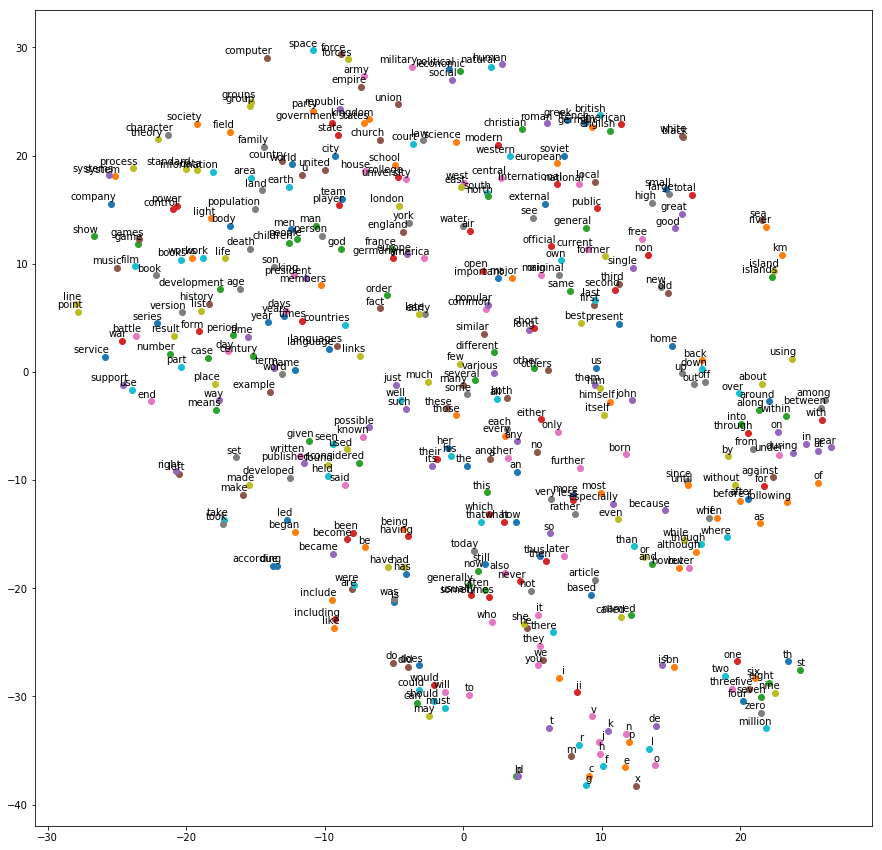

In [13]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)